# Pose Model Tracking in Babybrain Dataset

## Loading COCO-format Annotations
We transformed VIA-VGG 3.0.4 Video Annotations to COCO format using mybabybrain-database repository. Now let's load 
a subset of data from normal and abnormal class.

In [1]:
from qol import load_annotations


# load annotations
annotation_folder = '/home/harrisonford/Documents/babybrain-coco/'
normal_set = ['000345']
abnormal_set = ['000845']
suffix = ''
normal_annotations = [load_annotations(annotation_folder + a_file + suffix + '_coco.json') for a_file in normal_set]
abnormal_annotations = [load_annotations(annotation_folder + a_file + suffix + '_coco.json') for a_file in abnormal_set]

## Loading video frames 
Load video frames annotated in files

In [2]:
from qol import times_to_frames, get_frames_from


video_folder = '/home/harrisonford/Videos/babybrain/'
# extract times (id) to load from annotations, so we can load frames later
normal_frames = [[image_dict['id'] for image_dict in annotation['images']] for annotation in normal_annotations]
abnormal_frames = [[image_dict['id'] for image_dict in annotation['images']] for annotation in abnormal_annotations]

# transform each time id to frame id
frame_ids_normal = [times_to_frames(ids) for ids in normal_frames]
frame_ids_abnormal = [times_to_frames(ids) for ids in abnormal_frames]

# get the frames from video, this takes a while
normal_images = [get_frames_from(video_folder + video + '.MP4', frame_list, threshold=1) 
                          for (video, frame_list) in zip(normal_set, frame_ids_normal)]
abnormal_images = [get_frames_from(video_folder + video + '.MP4', frame_list, threshold=1) 
                            for (video, frame_list) in zip(abnormal_set, frame_ids_abnormal)]

## Using PoseEstimation and HumanPose models on images

[2019-09-25 09:16:49,588] [TfPoseEstimator] [INFO] loading graph from /home/harrisonford/PycharmProjects/mybabybrain-model/PoseEstimation/models/graph/cmu/graph_opt.pb(default size=432x368)
I0925 09:16:49.588136 140720066127680 estimator.py:308] loading graph from /home/harrisonford/PycharmProjects/mybabybrain-model/PoseEstimation/models/graph/cmu/graph_opt.pb(default size=432x368)


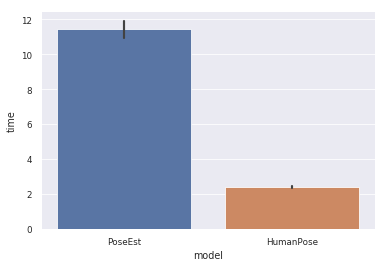

In [5]:
from poseModels import PoseEstimationModel, HumanPoseModel
import tensorflow as tf
import timeit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


tf.reset_default_graph()
pose_model = PoseEstimationModel()
id_list = []
times = []

# use pose model
for a_video_container, video_ids in zip(normal_images + abnormal_images, normal_frames + abnormal_frames):
    for an_image, an_id in zip(a_video_container, video_ids):
        tic = timeit.default_timer()
        pose_model.outputs.append(pose_model._run_model_once(an_image))
        toc = timeit.default_timer()
        times.append([toc - tic, 'PoseEst'])
        id_list.append(an_id)
# save tracking in coco format
output_json = '/home/harrisonford/Documents/coco_pose_model.json'
pose_model.save_as_coco_result(output_json, id_vector=id_list)

# now use the other model
tf.reset_default_graph()
human_model = HumanPoseModel()
for a_video_container, video_ids in zip(normal_images + abnormal_images, normal_frames + abnormal_frames):
    for an_image, an_id in zip(a_video_container, video_ids):
        tic = timeit.default_timer()
        human_model.outputs.append(human_model._run_model_once(an_image))
        toc = timeit.default_timer()
        times.append([toc - tic, 'HumanPose'])
output_json = '/home/harrisonford/Documents/coco_human_model.json'
human_model.save_as_coco_result(output_json, id_vector=id_list)

# plot avg computation time for each model
df = pd.DataFrame(times, columns=['time', 'model'])
sns.set("paper")
ax = sns.barplot(x='model', y='time', data=df)
plt.savefig('/home/harrisonford/Desktop/temp.png', dpi=1000)
plt.show()

## Check Center of Gravity movement

Calculating this may give us a hint about the movement patterns.

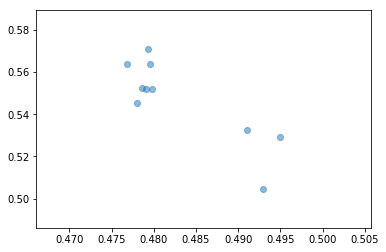

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# from the pose model outputs calculate mean center of gravity for each sample
center_of_gravities_x = []
center_of_gravities_y = []
for an_output in pose_model.outputs:
    x_values = []
    y_values = []
    for a_part in an_output.body_parts.values():  # stack x-y
        x_values.append(a_part.x)
        y_values.append(a_part.y)
    center_of_gravities_x.append(np.mean(x_values))
    center_of_gravities_y.append(np.mean(y_values))

# now plot it
plt.scatter(center_of_gravities_x, center_of_gravities_y, alpha=0.5)
plt.show()

## Checking model performances

In [5]:
from qol import compute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# calculate curve performance
distances_normal, visible_normal = \
    compute_error(output_json, annotation_folder + normal_set[0] + suffix +'_coco.json', normalize='body')

distances_abnormal, visible_abnormal = \
    compute_error(output_json, annotation_folder + abnormal_set[0] + suffix + '_coco.json', normalize='body')

# for each detection threshold count the data that falls in, for each joint
threshold = np.array(range(101))/100
threshold_total_count_normal = []
threshold_total_count_abnormal = []
for a_threshold in threshold:  # count for each threshold
    threshold_count_normal = np.zeros(distances_normal[0].shape)
    threshold_count_abnormal = np.zeros(distances_abnormal[0].shape)
    for a_sample_distance in distances_normal:  # accumulate from all samples
        for index, a_joint_distance in enumerate(a_sample_distance):  # for each joint
            if a_joint_distance <= a_threshold:
                threshold_count_normal[index] += 1
    for a_sample_distance in distances_abnormal:  # accumulate from all samples
        for index, a_joint_distance in enumerate(a_sample_distance):  # for each joint
            if a_joint_distance <= a_threshold:
                threshold_count_abnormal[index] += 1
    threshold_total_count_normal.append(threshold_count_normal)
    threshold_total_count_abnormal.append(threshold_count_abnormal)

# finally normalize by quantity
threshold_total_count_normal = [count_sample / len(normal_frames[0]) 
                                for count_sample in threshold_total_count_normal]
threshold_total_count_abnormal = [count_sample / len(abnormal_frames[0]) 
                                  for count_sample in threshold_total_count_abnormal]
# save in a data frame so it's easier to plot
data = []
left_mask = [0, 1, 5, 6, 7, 11, 12, 13, 15, 17]
right_mask = [0, 1, 2, 3, 4, 8, 9, 10, 14, 16]
graph_type = 'class'
mask_type = 'left'
for threshold_index, a_threshold in enumerate(threshold_total_count_normal):
    for joint_index, a_value in enumerate(a_threshold):
        if joint_index not in right_mask and graph_type == 'joint' and mask_type == 'right':
            continue
        if joint_index not in left_mask and graph_type == 'joint' and mask_type == 'left':
            continue
        data.append([threshold[threshold_index], joint_index, a_value, 'normal'])
for threshold_index, a_threshold in enumerate(threshold_total_count_abnormal):
    for joint_index, a_value in enumerate(a_threshold):
        if joint_index not in right_mask and graph_type == 'joint' and mask_type == 'right':
            continue
        if joint_index not in left_mask and graph_type == 'joint' and mask_type == 'left':
            continue
        data.append([threshold[threshold_index], joint_index, a_value, 'abnormal'])
df = pd.DataFrame(data=data, columns=['threshold', 'joint', 'ratio', 'class'])
sns.set("paper")
ax = sns.lineplot(x='threshold', y='ratio', data=df, hue=graph_type, palette='Paired')  # use hue=joint or class to change fig
plt.tight_layout()
if graph_type == 'joint':  # make custom legend
    joint_names = ['Nose', 'Neck', 'Shoulder', 'Elbow', 'Wrist', 'Hip', 'Knee', 'Ankle', 'Eye', 'Ear']
    plt.legend(title='Joint', labels=joint_names, loc='lower right', fontsize='x-small')
plt.savefig('/home/harrisonford/Desktop/temp.png', dpi=1000)
plt.show()

KeyboardInterrupt: 

## Calculate Confidence as Class Features
A fast way of classifying movement is by using confidence value outputs as some sort of
Transfer Learning approach, therefore we explore confidence values through different class
separations.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# read normal and abnormal confidence data
normal_path = './'
normal_df = pd.read_csv(normal_path)
abnormal_path = './'
abnormal_df = pd.read_csv(abnormal_path)

# plot bars normal vs abnormal
plt.figure()
wid = 0.25
plt.bar(np.arange(normal_df))  # TODO: Continue!